In [1]:
import os
from skimage import io
import pandas as pd
import face_recognition
import matplotlib.pyplot as plt
import torch
import numpy as np
import albumentations
from facenet_pytorch import MTCNN, InceptionResnetV1
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets

## Load Data

In [2]:
if os.environ.get('AM_I_ART_DATA') is not None:
    DATA_PATH = os.environ.get('AM_I_ART_DATA')
else:
    print( "Please set the environment variable AM_I_ART_DATA. Read the README!")

In [3]:
artists_path = os.path.join(DATA_PATH, "artists.csv")
artists_pd = pd.read_csv(artists_path)
artists_pd.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Generate test/art embedding

In [4]:
# Determine if an nvidia GPU is available
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


### Perfom MTCNN facial detection

In [5]:
mtcnn = MTCNN(
    image_size=150, margin=0, min_face_size=150,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [6]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4
dataset = datasets.ImageFolder( os.path.join(DATA_PATH, "images") )
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=4, drop_last=False, shuffle=False)

In [7]:
aligned = []
names = []
paths = []
indx = 0
for x, y in tqdm(loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])
        paths.append(dataset.imgs[indx][0])
    indx+=1

### Calculate image embeddings

In [8]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
aligned = torch.stack(aligned).to(device)

In [12]:
print(f"{aligned.shape}")

torch.Size([2192, 3, 150, 150])


In [40]:
embeddings = []
batch_size = 32
print(f"{aligned.size()[0]%batch_size} possible samples out")
for i in tqdm(range(0, aligned.size()[0], batch_size)):
    embeddings = embeddings + resnet(aligned[i:i+batch_size]).detach().cpu().numpy().tolist()
embeddings = np.array(embeddings)
print(embeddings.shape)

16 possible samples out



(2192, 512)


In [41]:
np.save("art_embeddings_hq_mtcnn.npy", np.array(embeddings))

In [43]:
df = pd.DataFrame({"face_path":paths}, columns=['face_path'])
df['artist'] = [face_path.split("/")[-2] for face_path in df['face_path']]
df.head()

,face_path,artist
0,/media/maparla/Almacen1/Datasets/art/images/Al...,Albrecht_Du¦êrer
1,/media/maparla/Almacen1/Datasets/art/images/Al...,Albrecht_Du¦êrer
2,/media/maparla/Almacen1/Datasets/art/images/Al...,Albrecht_Du¦êrer
3,/media/maparla/Almacen1/Datasets/art/images/Al...,Albrecht_Du¦êrer
4,/media/maparla/Almacen1/Datasets/art/images/Al...,Albrecht_Du¦êrer


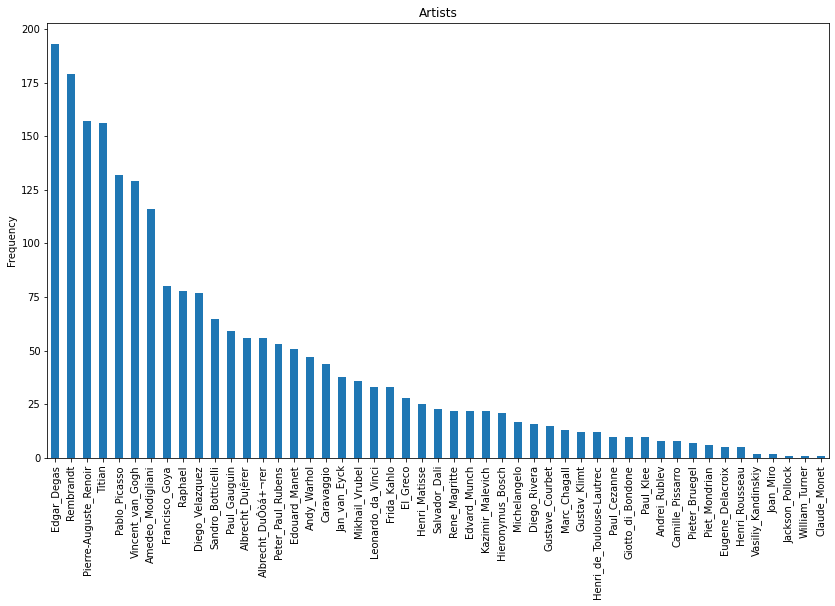

In [44]:
ax = df['artist'].value_counts().plot(kind='bar',figsize=(14,8), title="Artists")
ax.set_ylabel("Frequency")
plt.savefig("artist_frequency.jpg", bbox_inches='tight')
plt.show()

In [45]:
df.to_csv("embeddings_info_hq_mtcnn.csv", index=False)

## Find nearest embedding

In [46]:
art_embeddings = np.load("art_embeddings_hq_mtcnn.npy")
df = pd.read_csv("embeddings_info_hq_mtcnn.csv")

In [82]:
def get_embedding(face):
    return resnet(img_face.unsqueeze(0).to(device)).detach().cpu().numpy().squeeze(0)

In [83]:
def get_faces(img):
    x_aligned, prob = mtcnn(img, return_prob=True)
    return x_aligned

#### Example 1

(-0.5, 990.5, 557.5, -0.5)

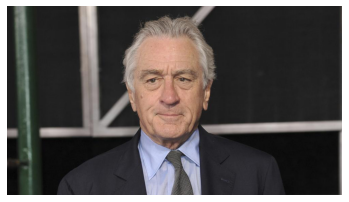

In [84]:
test_sample = face_recognition.load_image_file("samples/rdniro.jpg")
plt.imshow(test_sample); plt.axis("off")

In [85]:
img_face = get_faces(test_sample)
face_embedding = get_embedding(img_face)

In [87]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [89]:
nearest_item = df.iloc[nearest_indx]
nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))

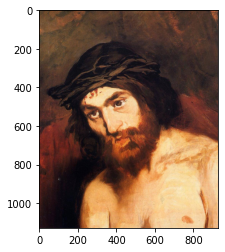

In [93]:
plt.imshow(nearest_img)

#### Example 2

(-0.5, 745.5, 443.5, -0.5)

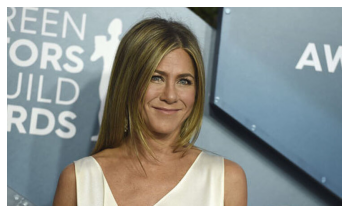

In [98]:
test_sample = face_recognition.load_image_file("samples/aniston.jpg")
plt.imshow(test_sample); plt.axis("off")

In [99]:
img_face = get_faces(test_sample)
face_embedding = get_embedding(img_face)

In [100]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [101]:
nearest_item = df.iloc[nearest_indx]
nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))

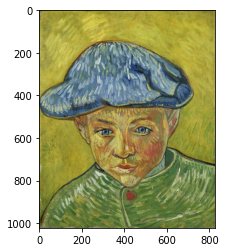

In [102]:
plt.imshow(nearest_img)

#### Example 3

(-0.5, 3871.5, 2591.5, -0.5)

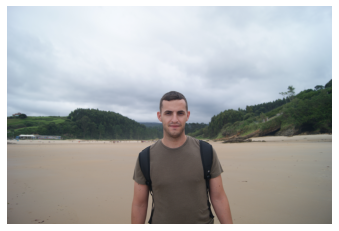

In [103]:
test_sample = face_recognition.load_image_file("samples/mario.JPG")
plt.imshow(test_sample); plt.axis("off")

In [104]:
img_face = get_faces(test_sample)
face_embedding = get_embedding(img_face)

In [105]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [106]:
nearest_item = df.iloc[nearest_indx]
nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))

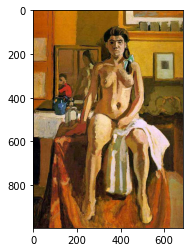

In [107]:
plt.imshow(nearest_img)

#### Example 4

(-0.5, 3871.5, 2591.5, -0.5)

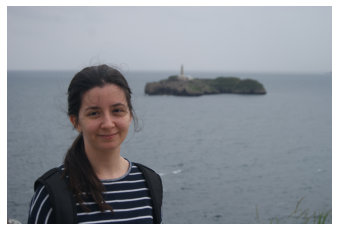

In [108]:
test_sample = face_recognition.load_image_file("samples/laura.JPG")
plt.imshow(test_sample); plt.axis("off")

In [109]:
img_face = get_faces(test_sample)
face_embedding = get_embedding(img_face)

In [110]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [111]:
nearest_item = df.iloc[nearest_indx]
nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))

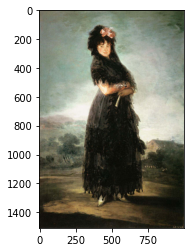

In [112]:
plt.imshow(nearest_img)

#### Example 5

(-0.5, 1199.5, 1599.5, -0.5)

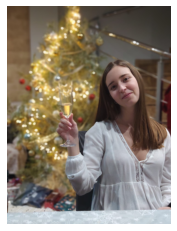

In [113]:
test_sample = face_recognition.load_image_file("samples/sara.jpg")
plt.imshow(test_sample); plt.axis("off")

In [114]:
img_face = get_faces(test_sample)
face_embedding = get_embedding(img_face)

In [115]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [116]:
nearest_item = df.iloc[nearest_indx]
nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))

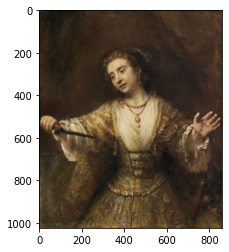

In [117]:
plt.imshow(nearest_img)